# Model validation

In this notebook, we validate the model that we have trained before. Therefore, a model from the models folder is loaded.

In [1]:
from pathlib import Path
import os
from PIL import Image
import torch
from torchvision import transforms, models
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

data_dir = "../data/test"
labels = ['fresh','blackspot','canker','grenning']
model_file = '../models/cross_validation_mobilenet_v2_final.pth'

## Load test dataset

In this part, we load the test data and load it into the pytorch dataloader

In [2]:
# Define image transformations (same as used during training)
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 128x128
    transforms.ToTensor(),  # Convert images to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize images
])

class OrangeDiseaseDataset(Dataset):
    def __init__(self, data_dir, labels, transform=None):
        self.data_dir = data_dir
        self.labels = labels
        self.transform = transform
        self.data = []
        self._load_images()

    def _load_images(self):
        for label in labels:
            label_dir = os.path.join(self.data_dir,label)
            [self.data.append((img_path, label)) for ext in ['*.jpg','*.png'] for img_path in Path(label_dir).rglob(ext)]

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label = self.data[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        label_idx = self.labels.index(label)
        return image, label_idx

# Create dataset
dataset = OrangeDiseaseDataset(data_dir, labels, transform=transform)
test_loader = DataLoader(dataset, batch_size=32, shuffle=False)

## Load the model

In this part, the model is loaded and moved to the GPU if available.

In [3]:
# Load the trained model
model = models.mobilenet_v2()
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, len(labels))
model.load_state_dict(torch.load(model_file, weights_only=True))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = model.to(device)

cuda:0


## Print evaluation report

The evluation report gives us information about the model performance on the test data. The following metrics are analyzed:

- Precision: It is the percentage of 

In [4]:
all_preds = []
all_labels = []
model.eval()
with torch.no_grad():
    for inputs, target_names in test_loader:
        inputs, target_names = inputs.to(device), target_names.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target_names.cpu().numpy())

# Classification report
print(classification_report(all_labels, all_preds, target_names=labels))

              precision    recall  f1-score   support

       fresh       1.00      1.00      1.00        33
   blackspot       0.90      0.86      0.88        22
      canker       0.87      0.91      0.89        22
    grenning       1.00      1.00      1.00        22

    accuracy                           0.95        99
   macro avg       0.94      0.94      0.94        99
weighted avg       0.95      0.95      0.95        99



## Confusion matrix

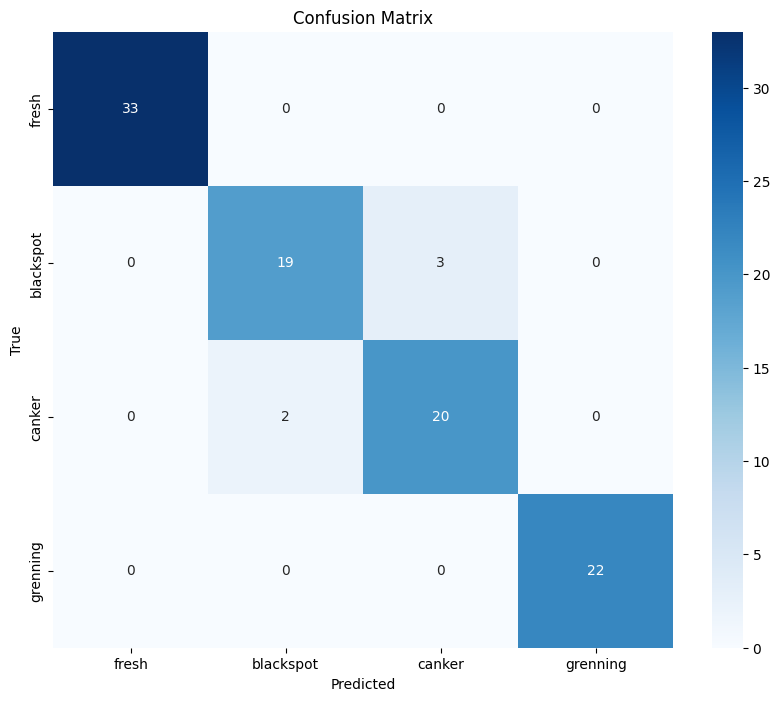

In [5]:
conf_matrix = confusion_matrix(all_labels, all_preds, labels=[0, 1, 2, 3])
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print all missclassified images

../data/test/blackspot/b (3).jpg


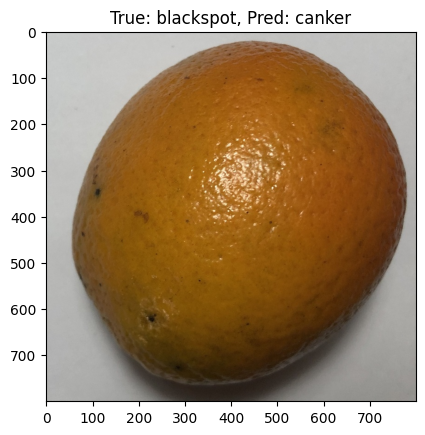

../data/test/blackspot/b (4).jpg


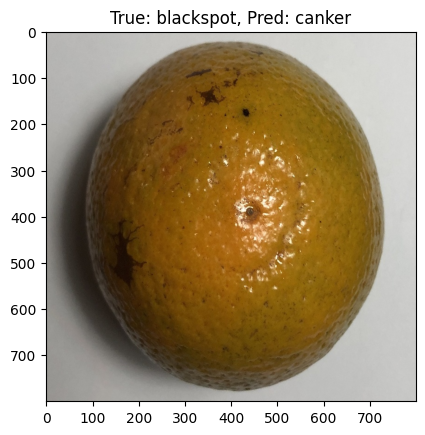

../data/test/blackspot/b (5).jpg


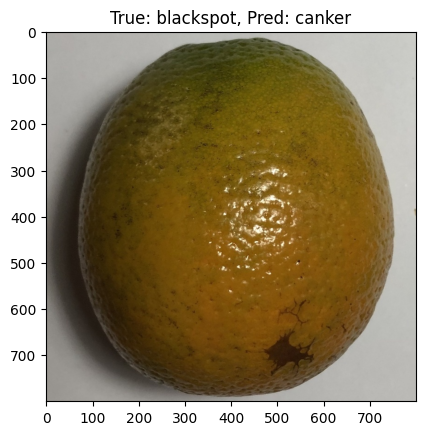

../data/test/canker/c (11).jpg


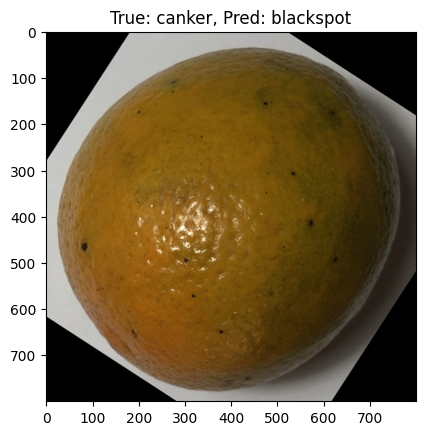

../data/test/canker/c (19).jpg


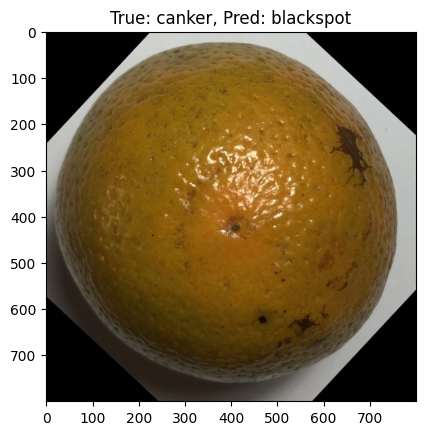

In [6]:
misclassified_images = []
misclassified_labels = []
misclassified_preds = []
for label, pred, img_path in zip(all_labels, all_preds, dataset.data):
    if label != pred:
        misclassified_images.append(img_path[0])
        misclassified_labels.append(label)
        misclassified_preds.append(pred)

# Display misclassified images
def imshow(img, title=None):
    """Helper function to show an image"""
    print(img)
    plt.imshow(Image.open(img))
    if title:
        plt.title(title)
    plt.show()

# Display the first 10 misclassified images
num_images = min(len(misclassified_images), 10)
for i in range(num_images):
    imshow(misclassified_images[i], title=f'True: {labels[misclassified_labels[i]]}, Pred: {labels[misclassified_preds[i]]}')

